### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline

# experimental script
import time
import timeit
import json
import pickle
import forest_surveyor.datasets as ds
from forest_surveyor.routines import experiment
from forest_surveyor import p_count
from forest_surveyor.structures import forest_walker, batch_getter, rule_accumulator
from forest_surveyor.routines import tune_rf_mp, tune_rf, train_rf, evaluate_model, run_batches, forest_survey, cor_incor_forest_survey
from forest_surveyor.plotting import log_ratio_plot, plot_mean_path_lengths, plot_varimp, plot_feature_stats, rule_profile_plots

In [2]:
# load a data set
mydata = ds.car_data()

# train test split
tt = mydata.tt_split()

################ PARAMETER TUNING ###################
############ Only runs when required ################
#####################################################

params = tune_rf(tt['X_train_enc'], tt['y_train'],
 save_path = mydata.pickle_path(),
 random_state=mydata.random_state)

#####################################################

# train a rf model
rf, enc_rf = train_rf(X=tt['X_train_enc'], y=tt['y_train'],
 params=params,
 encoder=tt['encoder'],
 random_state=mydata.random_state)

# only in interactive mode - evaluate and plot the confusion matrix
# evaluate_model(prediction_model=enc_rf, X=tt['X_test'], y=tt['y_test'],
#               class_names=mydata.class_names)

# don't print the plots but do print the returned cm
print(evaluate_model(prediction_model=enc_rf, X=tt['X_test'], y=tt['y_test'],
                     class_names=mydata.class_names,
                     plot_cm=False, plot_cm_norm=False))

Using existing params file. To re-tune, delete file at whiteboxing\car_pickles\params.json

Best OOB Cohen's Kappa during tuning: 0.9843
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1000}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Cohen's Kappa on unseen instances: 0.9588
[[152   2]
 [  7 358]]


In [3]:
# fit the forest_walker
f_walker = forest_walker(forest = rf,
 features=mydata.onehot_features,
 encoder=tt['encoder'],
 prediction_model=enc_rf)

# Part 1. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [4]:
# tuning params
# support - for freq patts in paths
# 0 < aplha_paths < 1 - greater favours longer rules
# sample instances and sample labels: training data, validation data, or new sample from target distribution to check for drift

# run the batch based forest walker
getter = batch_getter(instances=tt['X_test'], labels=tt['y_test'])

batch_size = 5
n_batches = 1

print('starting new run at: ' + time.asctime(time.gmtime()) + ' with batch_size = ' + str(batch_size) + ' and n_batches = ' + str(n_batches))
start_time = timeit.default_timer()

# rule_acc is just the last rule rule_accumulator, results are for the whole batch
rule_acc, results= run_batches(f_walker=f_walker,
 getter=getter,
 data_container=mydata,
 sample_instances=tt['X_train_enc'],
 sample_labels=tt['y_train'],
 support_paths=0.1,
 alpha_paths=0.5,
 which_trees='majority',
 batch_size = batch_size,
 n_batches = n_batches)

end_time = timeit.default_timer()
print('ending run at: ' + time.asctime(time.gmtime()))

elapsed_time = end_time - start_time
print('elapsed time (seconds) = ' + str(elapsed_time))

starting new run at: Sat Apr 14 17:39:32 2018 with batch_size = 5 and n_batches = 1
done batch 0
ending run at: Sat Apr 14 17:39:34 2018
elapsed time (seconds) = 2.780109099105128


In [19]:
print(results[1][0].instance_id)
mydata.pretty_rule(results[1][0].pruned_rule)

1296


['buying_vhigh False', 'maint_vhigh False', 'persons_2 False']

In [16]:
mydata.data.loc[1296]

buying             low
maint            vhigh
doors                2
persons              2
lug_boot         small
safety             low
acceptability    unacc
Name: 1296, dtype: object

In [22]:
tt['X_test']

NameError: name 'le_dict' is not defined

In [6]:
[pr for pr in map(mydata.pretty_rule, [best_rule[r][0] for r in range(len(best_rule))])]
_ = [rule_profile_plots(rule_acc[i], ds.car_data().class_names, alpha_scores=0.5, ig=False, cp=False) for i in range(len(rule_acc))]

for r in range(len(best_rule)):
    idx = rule_acc[0].apply_rule(best_rule[r][0])
    print(mydata.pretty_rule(best_rule[r][0]), p_count(tt['y_train'].loc[idx]))

NameError: name 'best_rule' is not defined

In [13]:
mydata.pretty_rule(rule_acc[0].pruned_rule)

['priors <= 0.60938',
 'tservd <= 13.79397',
 'tservd > 1.5',
 'age <= 286.04104',
 'age > 216.70149',
 'white <= 0.5',
 'workrel <= 0.5',
 'follow <= 52.46667',
 'rule <= 0.5',
 'school > 9.4',
 'felon <= 0.5']

In [9]:
[p[ra.target_class] for p in ra.pri_and_post], # should be the same as precision below
            [c[ra.target_class] for c in ra.pri_and_post_coverage],
            [a[ra.target_class] for a in ra.pri_and_post_accuracy],
            ra.precision,
            ra.isolation_pos,
            len(ra.pruned_rule),
            



[[0.6184708554125662,
  0.5397260273972603,
  0.555921052631579,
  0.5610687022900763,
  0.5337423312883436,
  1.0],
 [1.0,
  0.24112607099143207,
  0.20685434516523868,
  0.1799265605875153,
  0.10648714810281518,
  0.0073439412484700125],
 [0.6184708554125662,
  0.40348221044663135,
  0.4072672218016654,
  0.4057532172596518,
  0.3898561695685087,
  0.38607115821347465],
 [0.6184708554125662,
  0.5397260273972603,
  0.555921052631579,
  0.5610687022900763,
  0.5337423312883436,
  1.0],
 0,
 6,

# Part 2. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [4]:
# run the full forest survey
tt_correct_stats, tt_incorrect_stats = cor_incor_forest_survey(
 f_walker = f_walker, X=tt['X_test'], y=tt['y_test'])

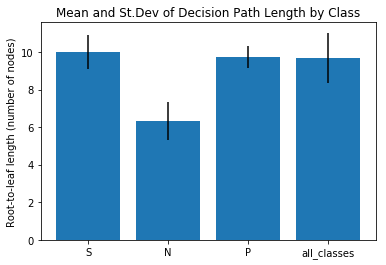

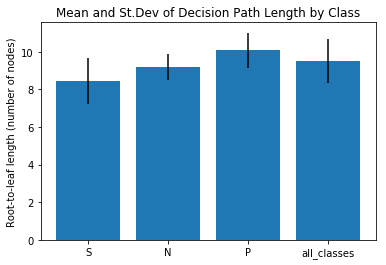

In [5]:
plot_mean_path_lengths(forest_stats=tt_correct_stats, class_names=mydata.class_names)
plot_mean_path_lengths(forest_stats=tt_incorrect_stats, class_names=mydata.class_names)

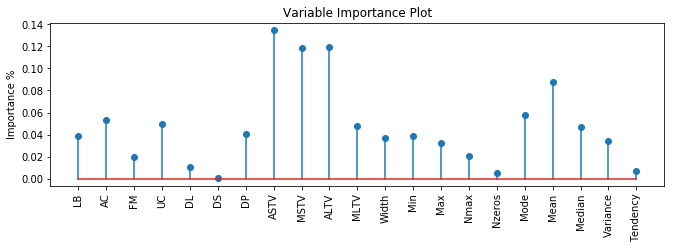

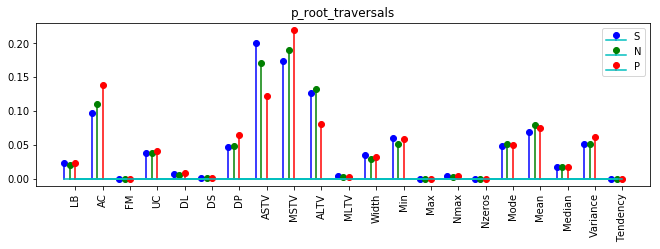

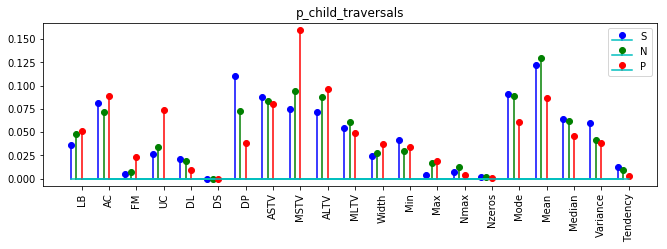

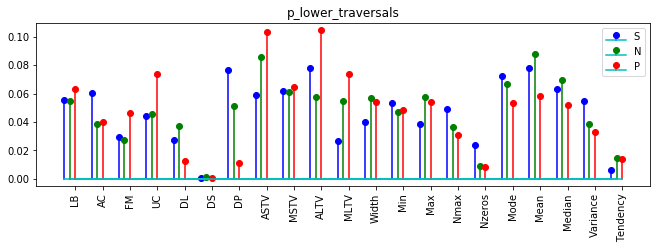

In [6]:
plot_varimp(rf, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_root_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_child_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_lower_traversals', mydata.class_names, mydata.onehot_features)

C:\dev\study\python\interpret_basics2\forest_surveyor\plotting.py:57: RuntimeWarning: invalid value encountered in true_divide
  log_ratio = np.log(num/denom)
C:\dev\study\python\interpret_basics2\forest_surveyor\plotting.py:69: RuntimeWarning: invalid value encountered in true_divide
  yerr = 0.434*np.sqrt((num_err/num)**2 + (denom_err/denom)**2)


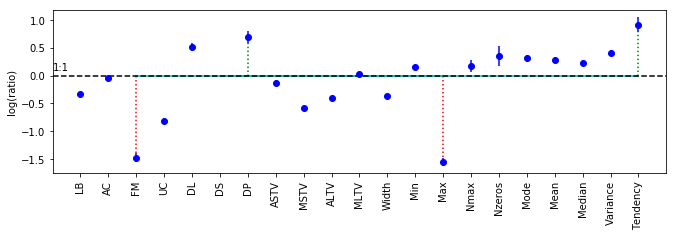

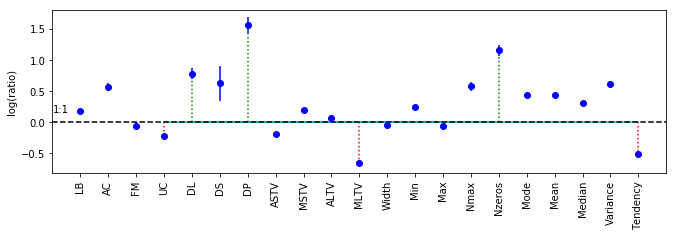

In [15]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = mydata.onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = mydata.onehot_features
)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [3]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

NameError: name 'rf' is not defined

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()

In [ ]:
%run whiteboxing_exp1.py

In [ ]:
params